# Week 5: GANs [I’m Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started)

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

## The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

## Submission format
Your kernel's output must be called `images.zip` and contain 7,000-10,000 images sized 256x256.

### 1. Dataset Description
The dataset contains four directories: `monet_tfrec`, `photo_tfrec`, `monet_jpg`, and `photo_jpg`. The `monet_tfrec` and `monet_jpg` directories contain the same painting images, and the `photo_tfrec` and `photo_jpg` directories contain the same photos.

We recommend using TFRecords as a Getting Started competition is a great way to become more familiar with a new data format, but JPEG images have also been provided.

The `monet` directories contain Monet paintings. Use these images to train your model.

The `photo` directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.

Note: Monet-style art can be created from scratch using other GAN architectures like DCGAN. The submitted image files do not necessarily have to be transformed photos.

Check out the [CycleGAN dataset](https://github.com/junyanz/CycleGAN) to experiment with the artistic style of other artists.

**Files**
- **monet_jpg** - 300 Monet paintings sized 256x256 in JPEG format
- **monet_tfrec** - 300 Monet paintings sized 256x256 in TFRecord format
- **photo_jpg** - 7028 photos sized 256x256 in JPEG format
- **photo_tfrec** - 7028 photos sized 256x256 in TFRecord format

### 2. Exploratory Data Analysis (EDA) — Inspect and Visualize the Data

In [20]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import os
from pathlib import Path
import cv2
import time
from zipfile import ZipFile

In [2]:
# Global Variables
MONET_JPG_PATH = 'data/monet_jpg'
PHOTO_JPG_PATH = 'data/photo_jpg'
MONET_TFREC_PATH = 'data/monet_tfrec'
PHOTO_TFREC_PATH = 'data/photo_tfrec'

IMG_WIDTH = 256
IMG_HEIGHT = 256

In [3]:
# Setting random seeds is an important practice in machine learning for reproducibility.
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Load a display sample images
def load_jpg_images(directory):
    """Load random sample images from directory"""
    if not os.path.exists(directory):
        print(f"Directory {directory} not found!")
        return []
    image_files = [f for f in os.listdir(directory) if f.endswith('.jpg')]
    images = []
    for file in image_files:
        img_path = os.path.join(directory, file)
        img = Image.open(img_path)
        images.append(np.array(img))
    
    return images

def display_images(images, title, n_cols=5):
    """Display images in a grid"""
    n_images = len(images)
    n_rows = 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, ax in enumerate(axes.flat):
        if idx < n_images:
            ax.imshow(images[idx])
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

monet_jpgs = load_jpg_images(MONET_JPG_PATH)
monet_jpgs = monet_jpgs[:50]                   ####### Show for 50 only! My laptop can't handle bigger datasets #######
print(f"monet_jpg: {len(monet_jpgs)} images")

photo_jpgs = load_jpg_images(PHOTO_JPG_PATH)
photo_jpgs = photo_jpgs[:50]                   ####### Show for 50 only! My laptop can't handle bigger datasets #######  
print(f"photo_jpg: {len(photo_jpgs)} images")

monet_jpg: 50 images
photo_jpg: 50 images


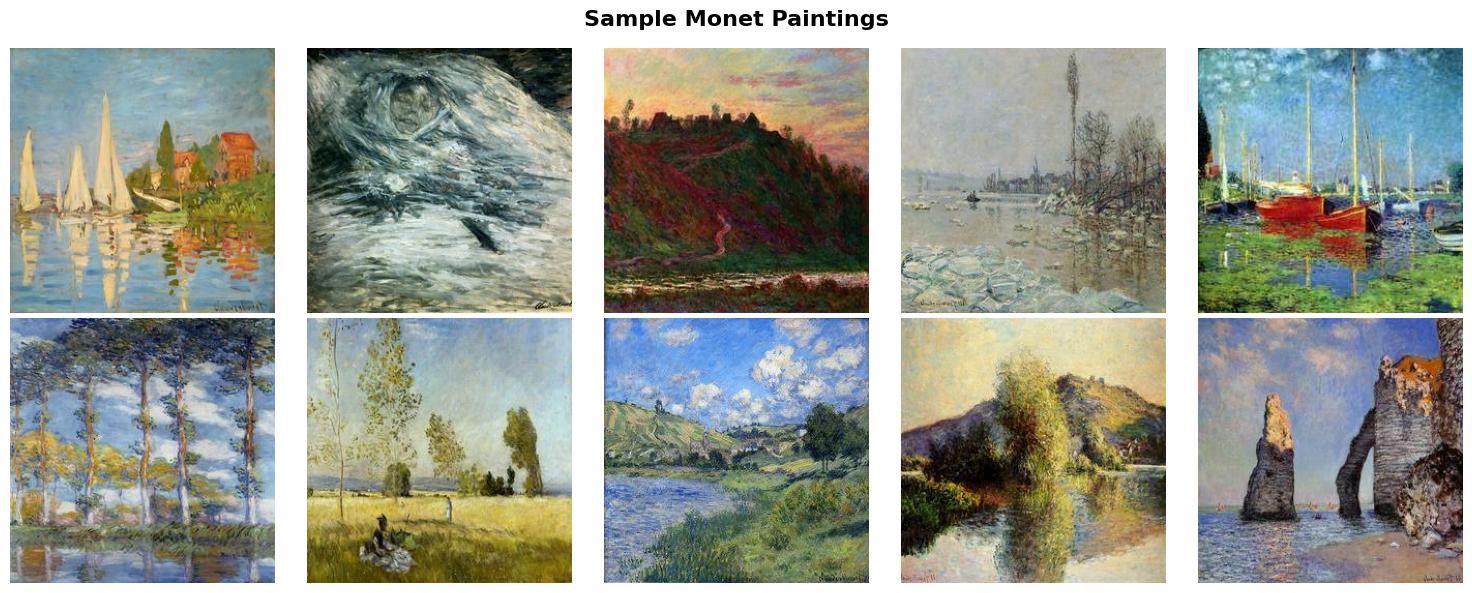

In [5]:
display_images(monet_jpgs, "Sample Monet Paintings", n_cols=5)

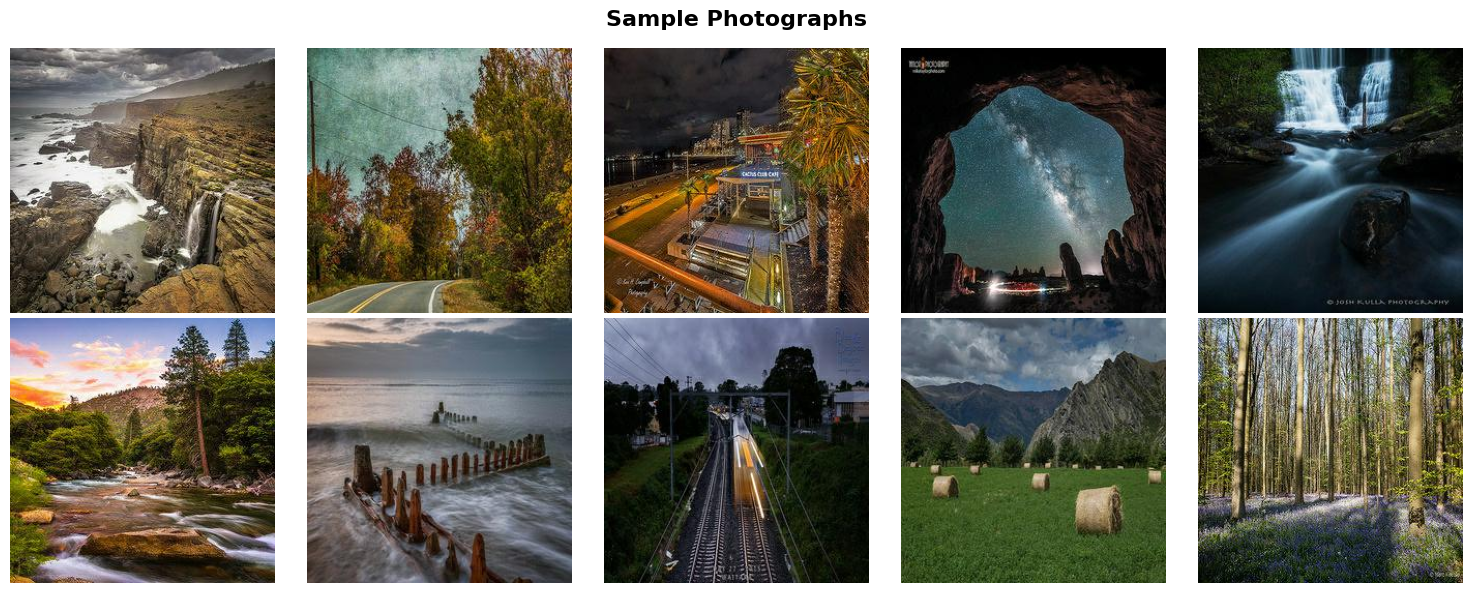

In [6]:
display_images(photo_jpgs, "Sample Photographs", n_cols=5)

In [7]:
# Helper function for color distribution analysis
def analyze_color_distribution(images, title):
    """Analyze and plot RGB color distributions"""
    r_values, g_values, b_values = [], [], []
    
    for img in images:
        r_values.extend(img[:, :, 0].flatten())
        g_values.extend(img[:, :, 1].flatten())
        b_values.extend(img[:, :, 2].flatten())
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'{title} - RGB Distribution', fontsize=14, fontweight='bold')
    
    # Red channel
    axes[0].hist(r_values, bins=50, color='red', alpha=0.7, edgecolor='black')
    axes[0].set_title('Red Channel')
    axes[0].set_xlabel('Pixel Intensity')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)
    
    # Green channel
    axes[1].hist(g_values, bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[1].set_title('Green Channel')
    axes[1].set_xlabel('Pixel Intensity')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    # Blue channel
    axes[2].hist(b_values, bins=50, color='blue', alpha=0.7, edgecolor='black')
    axes[2].set_title('Blue Channel')
    axes[2].set_xlabel('Pixel Intensity')
    axes[2].set_ylabel('Frequency')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

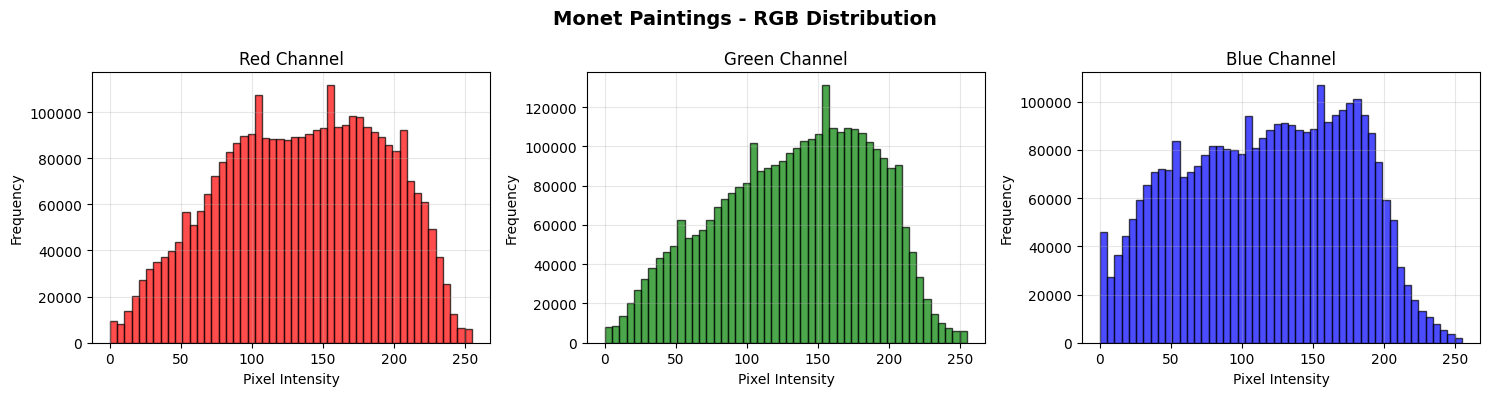

In [8]:
analyze_color_distribution(monet_jpgs, "Monet Paintings")

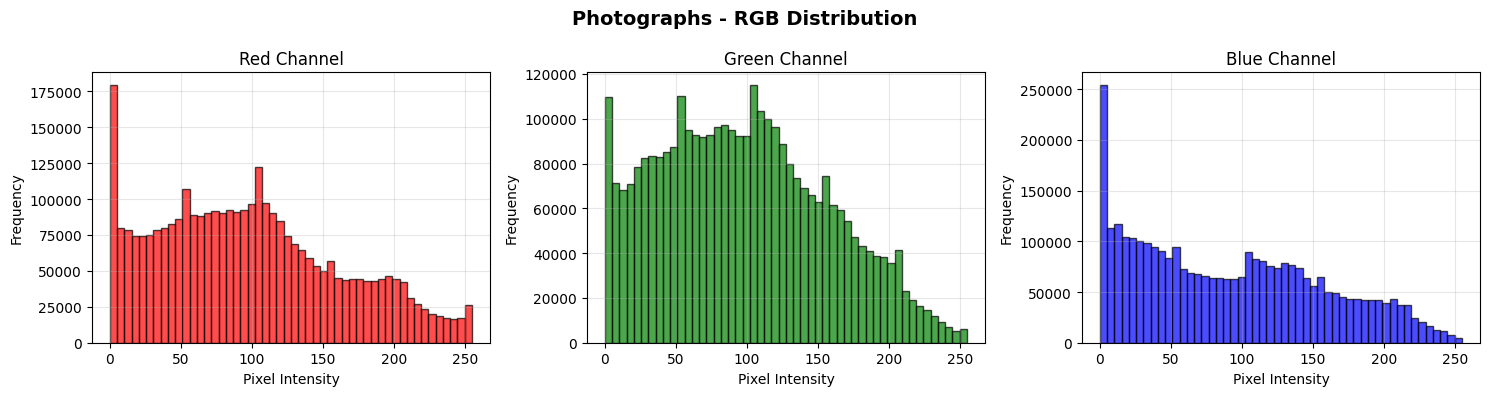

In [9]:
analyze_color_distribution(photo_jpgs, "Photographs")

In [10]:
# Helper function for brightness and contrast analysis
def analyze_brightness_contrast(images, title):
    """Analyze brightness and contrast of images"""
    brightness_values = []
    contrast_values = []
    
    for img in images:
        # Convert to grayscale for brightness/contrast analysis
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        brightness = np.mean(gray)
        contrast = np.std(gray)
        
        brightness_values.append(brightness)
        contrast_values.append(contrast)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'{title} - Brightness and Contrast', fontsize=14, fontweight='bold')
    
    # Brightness
    axes[0].hist(brightness_values, bins=20, color='orange', alpha=0.7, edgecolor='black')
    axes[0].set_title('Brightness Distribution')
    axes[0].set_xlabel('Mean Brightness')
    axes[0].set_ylabel('Frequency')
    axes[0].axvline(np.mean(brightness_values), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(brightness_values):.2f}')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Contrast
    axes[1].hist(contrast_values, bins=20, color='purple', alpha=0.7, edgecolor='black')
    axes[1].set_title('Contrast Distribution')
    axes[1].set_xlabel('Standard Deviation (Contrast)')
    axes[1].set_ylabel('Frequency')
    axes[1].axvline(np.mean(contrast_values), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(contrast_values):.2f}')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

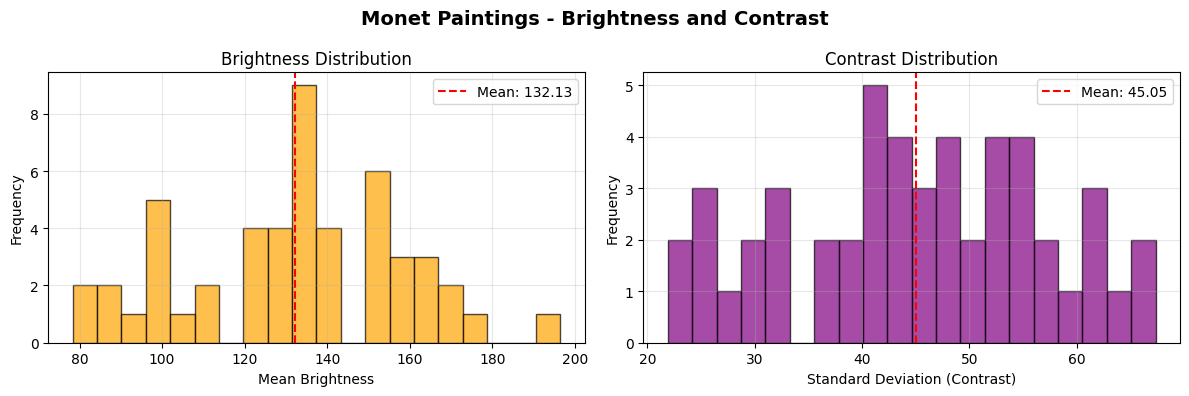

In [11]:
analyze_brightness_contrast(monet_jpgs, "Monet Paintings")

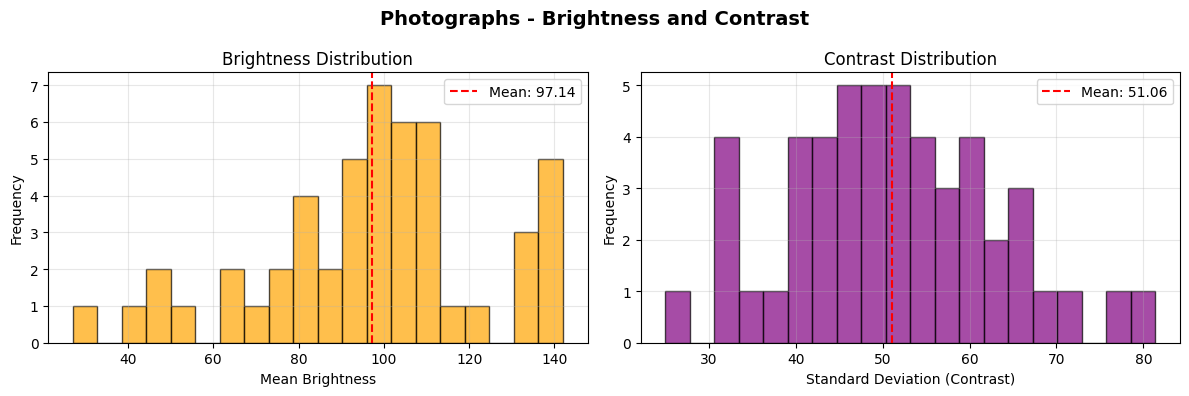

In [12]:
analyze_brightness_contrast(photo_jpgs, "Photographs")

In [13]:
def analyze_edges(images, title, sample_idx=0):
    """Analyze edges using Canny edge detection"""
    if len(images) == 0:
        return
    
    sample_img = images[sample_idx]
    gray = cv2.cvtColor(sample_img, cv2.COLOR_RGB2GRAY)
    
    # Apply Canny edge detection with different thresholds
    edges_low = cv2.Canny(gray, 50, 150)
    edges_high = cv2.Canny(gray, 100, 200)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{title} - Edge Detection Analysis', fontsize=14, fontweight='bold')
    
    axes[0].imshow(sample_img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(edges_low, cmap='gray')
    axes[1].set_title('Edges (Low Threshold)')
    axes[1].axis('off')
    
    axes[2].imshow(edges_high, cmap='gray')
    axes[2].set_title('Edges (High Threshold)')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

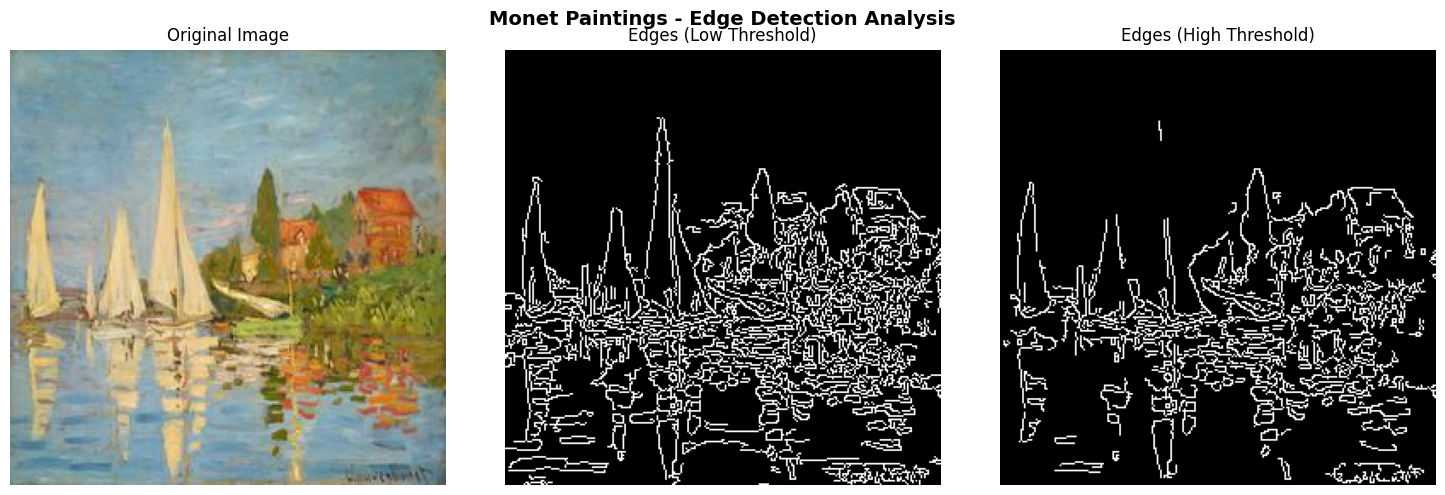

In [14]:
analyze_edges(monet_jpgs, "Monet Paintings")

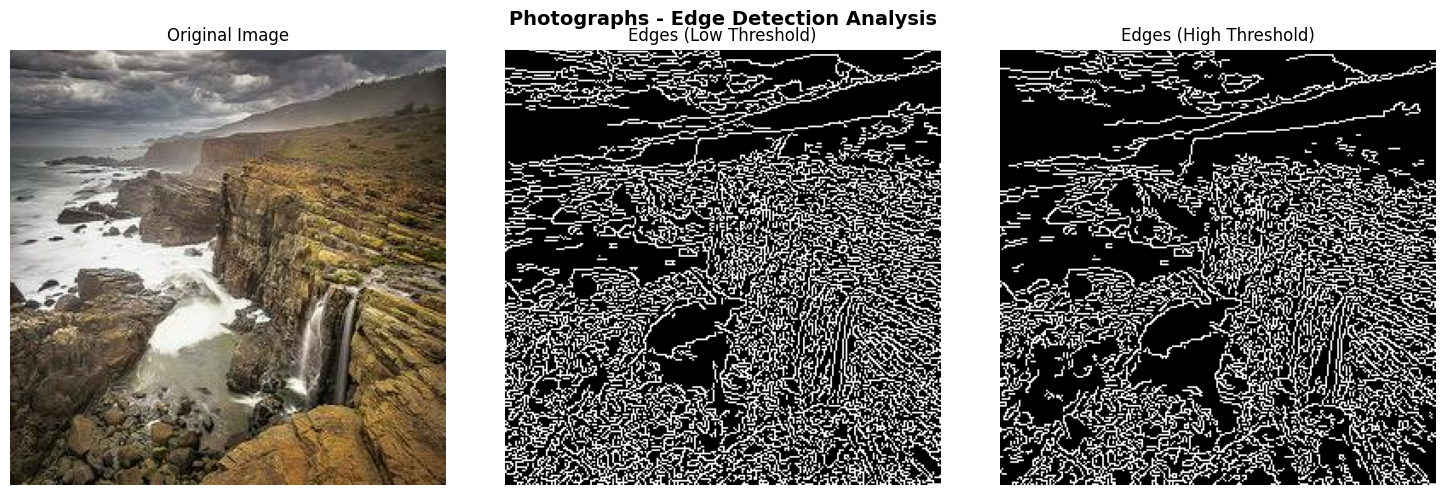

In [15]:
analyze_edges(photo_jpgs, "Photographs")

### 3. Model Building, Training and Results

In [4]:
# Global variables for configuration and hyperparameters

# Training configuration
BATCH_SIZE = 1              # Small batch size for memory constraints
BUFFER_SIZE = 1000          # Let's keep it to 1000 for now!
IMG_SHAPE = (256, 256, 3)

# Loss weights
LAMBDA_CYCLE = 10.0  # Cycle consistency loss weight
LAMBDA_IDENTITY = 0.5  # Identity loss weight (optional, helps preserve colors)

# Learning rate
LEARNING_RATE = 2e-4

# Checkpoint settings
CHECKPOINT_DIR = './training_checkpoints'
CHECKPOINT_PREFIX = os.path.join(CHECKPOINT_DIR, "ckpt")

# Output settings
OUTPUT_DIR = './generated_images'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
# Data Loading from TFR files
def decode_image(image):
    """Decode TFRecord image"""
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    image = tf.reshape(image, [IMG_WIDTH, IMG_HEIGHT, 3])
    return image

def read_tfrecord(example):
    """Parse TFRecord example"""
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    """Load TFRecord dataset"""
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset

def get_dataset(tfrecord_path, augment=False):
    """Create dataset pipeline"""
    filenames = tf.io.gfile.glob(f'{tfrecord_path}/*.tfrec')
    dataset = load_dataset(filenames)
    
    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache()
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

def data_augment(image):
    """Apply random data augmentation"""
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random brightness
    image = tf.image.random_brightness(image, 0.1)
    # Random contrast
    image = tf.image.random_contrast(image, 0.9, 1.1)
    # Clip to valid range
    image = tf.clip_by_value(image, -1, 1)
    return image

# Load datasets
monet_dataset = get_dataset(MONET_TFREC_PATH, augment=True)
photo_dataset = get_dataset(PHOTO_TFREC_PATH, augment=False)

In [6]:
# Custom Instance Normalization Layer
class InstanceNormalization(tf.keras.layers.Layer):
    """Replacement for deprecated tensorflow_addons"""
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon
    
    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True
        )
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True
        )
    
    def call(self, x):
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

In [7]:
# Generator Architecture
def downsample(filters, size, apply_instancenorm=True):
    """Downsampling block"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2D(
        filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False
    ))
    
    if apply_instancenorm:
        result.add(InstanceNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    result = tf.keras.Sequential()
    result.add(tf.keras.layers.Conv2DTranspose(
        filters, size, strides=2, padding='same',
        kernel_initializer=initializer, use_bias=False
    ))
    
    result.add(InstanceNormalization())
    
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    
    result.add(tf.keras.layers.ReLU())
    return result

def Generator():
    """U-Net Generator"""
    inputs = tf.keras.layers.Input(shape=IMG_SHAPE)
    
    # Downsampling
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    
    # Upsampling
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),   # (bs, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        3, 4, strides=2, padding='same',
        kernel_initializer=initializer,
        activation='tanh'
    )  # (bs, 256, 256, 3)
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])
    
    x = last(x)
    
    return tf.keras.Model(inputs=inputs, outputs=x)

In [8]:
# Create generators
generator_g = Generator()  # Photo -> Monet
generator_f = Generator()  # Monet -> Photo

In [9]:
# Discriminator Architecture
def Discriminator():
    """PatchGAN Discriminator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    
    inp = tf.keras.layers.Input(shape=IMG_SHAPE, name='input_image')
    
    x = inp
    
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)     # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)     # (bs, 32, 32, 256)
    
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(
        512, 4, strides=1,
        kernel_initializer=initializer,
        use_bias=False
    )(zero_pad1)  # (bs, 31, 31, 512)
    
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)
    
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    
    last = tf.keras.layers.Conv2D(
        1, 4, strides=1,
        kernel_initializer=initializer
    )(zero_pad2)  # (bs, 30, 30, 1)
    
    return tf.keras.Model(inputs=inp, outputs=last)

In [10]:
# Create discriminators
discriminator_x = Discriminator()  # Discriminates photos
discriminator_y = Discriminator()  # Discriminates Monet paintings

In [11]:
# Create Optimizers

generator_g_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE, beta_1=0.5)

In [12]:
# Loss Functions
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    """Discriminator loss"""
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    """Generator loss (adversarial loss)"""
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    """Cycle consistency loss"""
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA_CYCLE * loss

def identity_loss(real_image, same_image):
    """Identity loss (helps preserve colors)"""
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA_CYCLE * LAMBDA_IDENTITY * loss

In [13]:
# Checkpoint Management

checkpoint = tf.train.Checkpoint(
    generator_g=generator_g,
    generator_f=generator_f,
    discriminator_x=discriminator_x,
    discriminator_y=discriminator_y,
    generator_g_optimizer=generator_g_optimizer,
    generator_f_optimizer=generator_f_optimizer,
    discriminator_x_optimizer=discriminator_x_optimizer,
    discriminator_y_optimizer=discriminator_y_optimizer
)

checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, CHECKPOINT_DIR, max_to_keep=5
)

# Restore checkpoint if exists
if checkpoint_manager.latest_checkpoint:
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    print(f'Restored from checkpoint: {checkpoint_manager.latest_checkpoint}')
else:
    print('No checkpoint found. Starting from scratch.')

No checkpoint found. Starting from scratch.


In [14]:
# Training Step
@tf.function
def train_step(real_x, real_y):
    """Single training step"""
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)
        
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)
        
        # same_x and same_y are for identity loss
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)
        
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)
        
        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)
        
        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)
        
        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
        
        # Total generator loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
        
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    
    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)
    
    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))
    
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [15]:
# Training Loop with Progress Visualization
def generate_and_save_images(model, test_input, epoch):
    """Generate and save sample images during training"""
    prediction = model(test_input, training=False)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Generated Image']
    
    for i in range(2):
        axes[i].set_title(title[i])
        # Denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(display_list[i] * 0.5 + 0.5)
        axes[i].axis('off')
    
    plt.suptitle(f'Epoch {epoch}')
    plt.tight_layout()
    plt.show()

In [16]:
# Main Training Loop
def train(epochs):
    """Main training loop"""
    history = {
        'gen_g_loss': [],
        'gen_f_loss': [],
        'disc_x_loss': [],
        'disc_y_loss': []
    }
    
    for epoch in range(epochs):
        start = time.time()
        
        n_batches = 0
        epoch_gen_g_loss = 0
        epoch_gen_f_loss = 0
        epoch_disc_x_loss = 0
        epoch_disc_y_loss = 0
        
        # Train
        for image_x, image_y in tf.data.Dataset.zip((photo_dataset, monet_dataset)):
            gen_g_loss, gen_f_loss, disc_x_loss, disc_y_loss = train_step(image_x, image_y)
            
            epoch_gen_g_loss += gen_g_loss
            epoch_gen_f_loss += gen_f_loss
            epoch_disc_x_loss += disc_x_loss
            epoch_disc_y_loss += disc_y_loss
            n_batches += 1
        
        # Calculate average losses
        avg_gen_g_loss = epoch_gen_g_loss / n_batches
        avg_gen_f_loss = epoch_gen_f_loss / n_batches
        avg_disc_x_loss = epoch_disc_x_loss / n_batches
        avg_disc_y_loss = epoch_disc_y_loss / n_batches
        
        history['gen_g_loss'].append(float(avg_gen_g_loss))
        history['gen_f_loss'].append(float(avg_gen_f_loss))
        history['disc_x_loss'].append(float(avg_disc_x_loss))
        history['disc_y_loss'].append(float(avg_disc_y_loss))
        
        # Display progress
        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'  Gen G Loss: {avg_gen_g_loss:.4f}')
        print(f'  Gen F Loss: {avg_gen_f_loss:.4f}')
        print(f'  Disc X Loss: {avg_disc_x_loss:.4f}')
        print(f'  Disc Y Loss: {avg_disc_y_loss:.4f}')
        print(f'  Time: {time.time() - start:.2f} sec\n')
        
        # Generate sample images every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_and_save_images(generator_g, sample_photo, epoch + 1)
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint_manager.save()
            print(f'Checkpoint saved at epoch {epoch + 1}\n')
    
    return history

In [17]:
# Training
EPOCHS = 4                             # Can adjust based on results
training_history = train(EPOCHS)
print("Training completed!")

2025-12-02 21:31:21.583733: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-12-02 21:31:24.575256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/4
  Gen G Loss: 5.4534
  Gen F Loss: 5.5163
  Disc X Loss: 0.6924
  Disc Y Loss: 0.6909
  Time: 929.28 sec



2025-12-02 21:46:32.774613: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-12-02 21:46:35.845779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/4
  Gen G Loss: 3.7430
  Gen F Loss: 3.7028
  Disc X Loss: 0.6571
  Disc Y Loss: 0.6387
  Time: 911.26 sec



2025-12-02 22:02:10.190356: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-12-02 22:02:13.190866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/4
  Gen G Loss: 3.3895
  Gen F Loss: 3.3894
  Disc X Loss: 0.6641
  Disc Y Loss: 0.6546
  Time: 937.36 sec



2025-12-02 22:17:55.901939: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4/4
  Gen G Loss: 3.2572
  Gen F Loss: 3.2490
  Disc X Loss: 0.6618
  Disc Y Loss: 0.6541
  Time: 946.07 sec

Training completed!


2025-12-02 22:17:59.271149: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


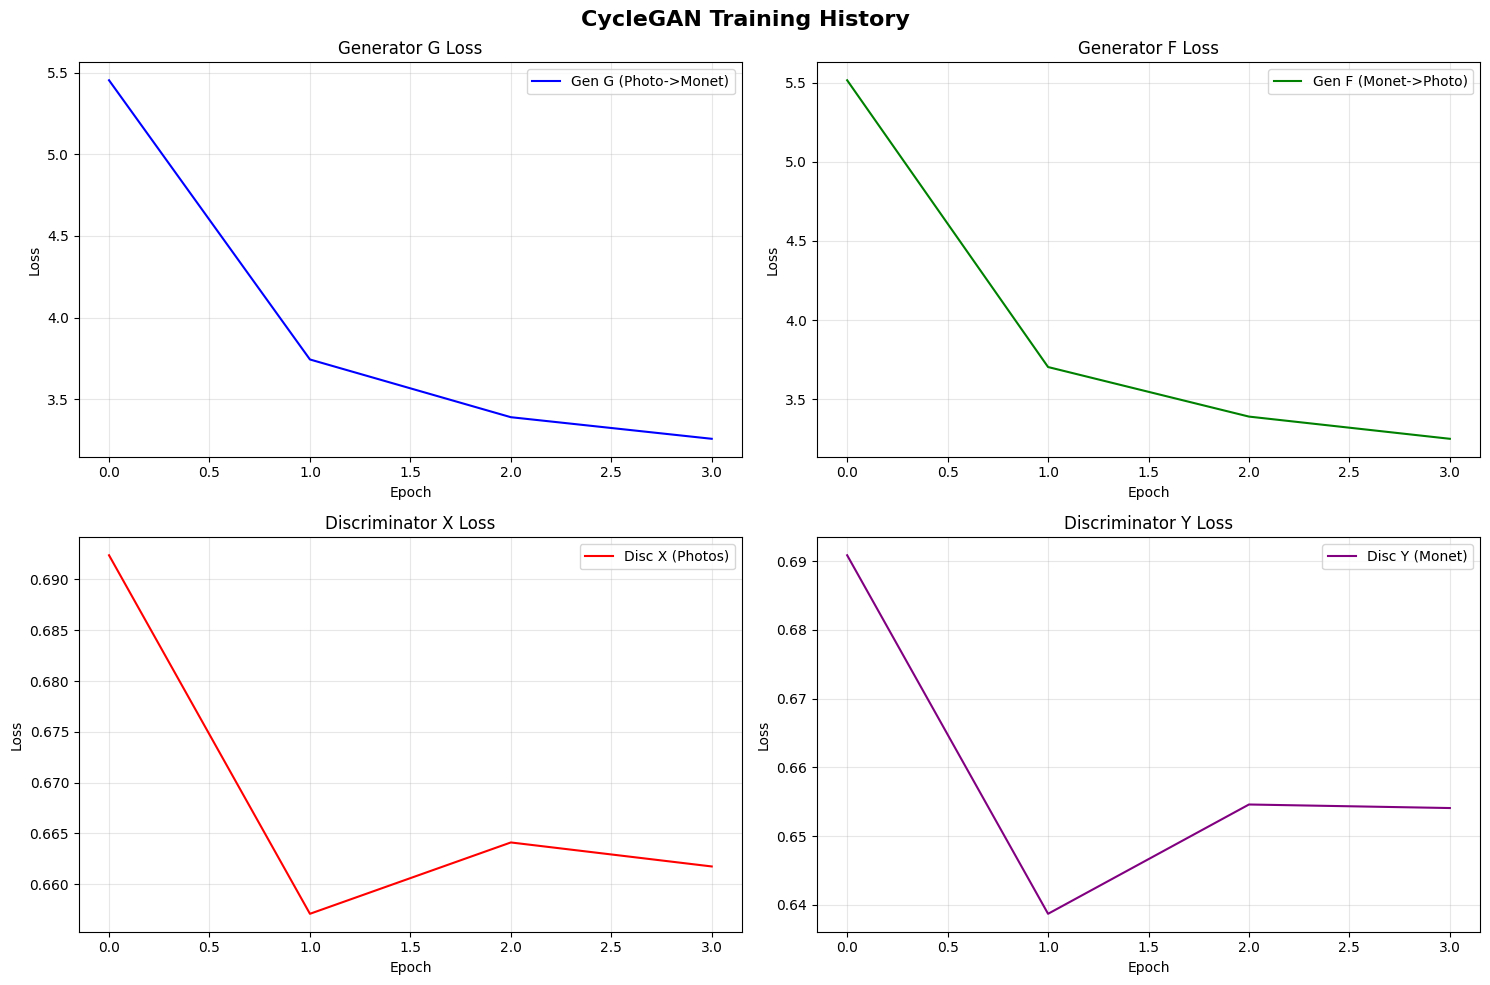

In [19]:
# Plot training history
def plot_training_history(history):
    """Plot training loss curves"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('CycleGAN Training History', fontsize=16, fontweight='bold')
    
    # Generator G loss
    axes[0, 0].plot(history['gen_g_loss'], label='Gen G (Photo->Monet)', color='blue')
    axes[0, 0].set_title('Generator G Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Generator F loss
    axes[0, 1].plot(history['gen_f_loss'], label='Gen F (Monet->Photo)', color='green')
    axes[0, 1].set_title('Generator F Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Discriminator X loss
    axes[1, 0].plot(history['disc_x_loss'], label='Disc X (Photos)', color='red')
    axes[1, 0].set_title('Discriminator X Loss')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Discriminator Y loss
    axes[1, 1].plot(history['disc_y_loss'], label='Disc Y (Monet)', color='purple')
    axes[1, 1].set_title('Discriminator Y Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(training_history)

In [22]:
# Helper function for generating monet images
def generate_monet_images():
    """Generate Monet-style images from all photos"""
    # Create dataset without batching for individual image processing
    photo_files = tf.io.gfile.glob(f'{PHOTO_TFREC_PATH}/*.tfrec')
    photo_ds = load_dataset(photo_files)
    
    image_count = 0
    for img in photo_ds:
        # Add batch dimension
        img_batch = tf.expand_dims(img, 0)
        
        # Generate Monet-style image
        prediction = generator_g(img_batch, training=False)[0]
        
        # Denormalize from [-1, 1] to [0, 255]
        prediction = (prediction * 127.5 + 127.5).numpy().astype(np.uint8)
        
        # Save image
        img_pil = Image.fromarray(prediction)
        img_path = os.path.join(OUTPUT_DIR, f'monet_{image_count:04d}.jpg')
        img_pil.save(img_path)
        
        image_count += 1
        
        if image_count % 500 == 0:
            print(f'Generated {image_count} images...')
    
    print(f'Total images generated: {image_count}')
    return image_count

num_generated = generate_monet_images()

Generated 500 images...
Generated 1000 images...
Generated 1500 images...
Generated 2000 images...
Generated 2500 images...
Generated 3000 images...
Generated 3500 images...
Generated 4000 images...
Generated 4500 images...
Generated 5000 images...
Generated 5500 images...
Generated 6000 images...
Generated 6500 images...
Generated 7000 images...
Total images generated: 7038


2025-12-06 08:31:24.851876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
# Create submission zip
def create_submission_zip():
    
    with ZipFile('images.zip', 'w') as zipf:
        for filename in os.listdir(OUTPUT_DIR):
            if filename.endswith('.jpg'):
                file_path = os.path.join(OUTPUT_DIR, filename)
                zipf.write(file_path, arcname=filename)
    
    print(f"Submission file {os.path.abspath('images.zip')} created successfully!")

create_submission_zip()

Submission file /Users/drivera53/Development/master/Introduction_to_Deep_Learning/introduction_to_deep_learning/Week5_GANs/images.zip created successfully!


2025-12-06 08:36:01.147245: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


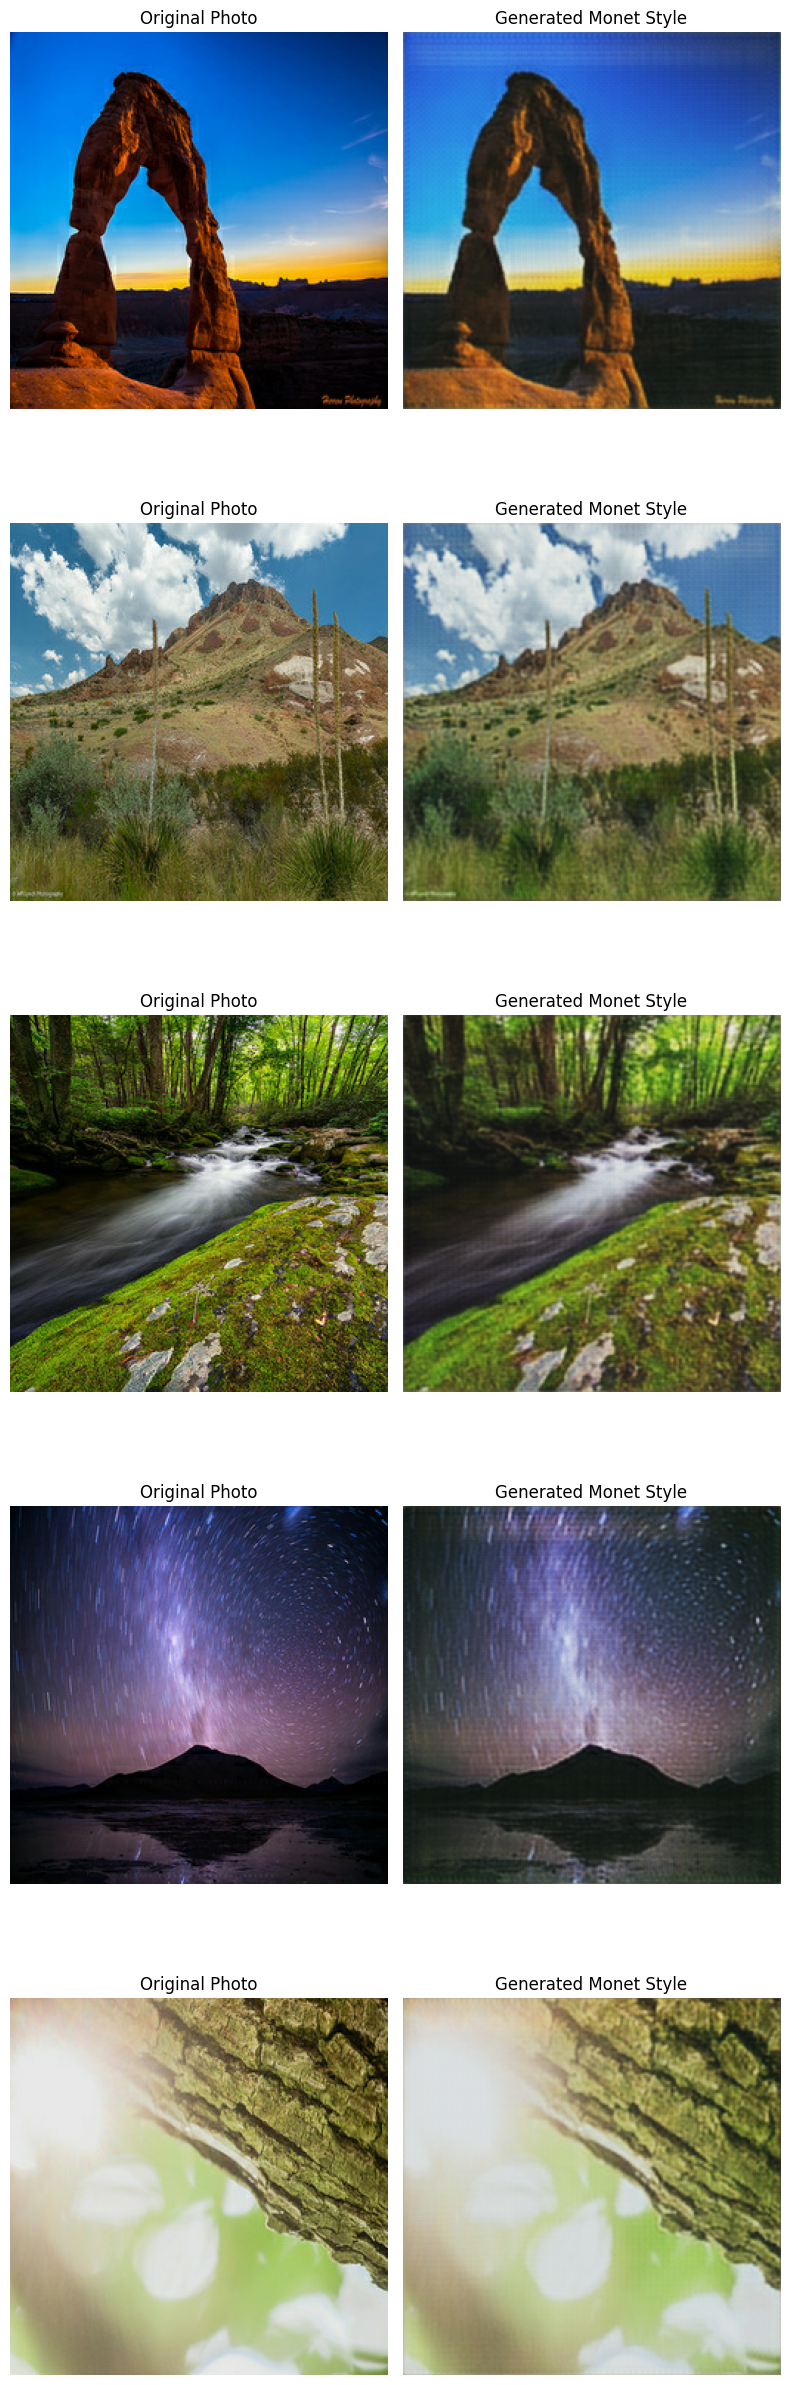

In [31]:
# Display sample results
def display_final_results(n_samples=5):
    photo_files = tf.io.gfile.glob(f'{PHOTO_TFREC_PATH}/*.tfrec')
    photo_ds = load_dataset(photo_files)
    samples = list(photo_ds.take(n_samples))
    fig, axes = plt.subplots(n_samples, 2, figsize=(8, 5 * n_samples))
    
    for i, img in enumerate(samples):
        # Original photo
        axes[i, 0].imshow(img * 0.5 + 0.5)
        axes[i, 0].set_title('Original Photo')
        axes[i, 0].axis('off')
        
        # Generated Monet-style
        img_batch = tf.expand_dims(img, 0)
        prediction = generator_g(img_batch, training=False)[0]
        axes[i, 1].imshow(prediction * 0.5 + 0.5)
        axes[i, 1].set_title('Generated Monet Style')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

display_final_results()

### 4. Conclusion

For this project I successfully implemented a **CycleGAN architecture** to transform photos into Monet-style paintings.

#### Constraints and Results

Due to **CPU hardware limitations** of my personal PC and time, training was restricted to only **4 epochs** compared to the typical 100-200 epochs recommended for CycleGAN convergence. That's why:

- Generated images show initial style transfer attempts but lack refinement
- Loss curves indicate the model was in early training stages
- Style transfer is visible but not as sophisticated as fully trained models

#### Future Improvements

With **GPU resources and extended training**, significant enhancements would include:

- **Extended Training**: 100+ epochs to learn nuanced Monet characteristics (brushstrokes, color harmony, impressionistic textures)
- **Hyperparameter Tuning**: Optimize loss weights, learning rates, and batch sizes beyond current memory constraints

Despite computational constraints limiting visual quality, this project demonstrates a **complete, functional CycleGAN implementation** with a solid foundation for future enhancement given adequate computational resources.